### EDA {exploratory data analysis}

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create a data-frame for train.csv
df = pd.read_csv("train.csv")
df = df.sample(30000, random_state = 42)
df.shape

(30000, 6)

In [3]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
297,297,594,595,Why did the puppet they used for Yoda in Episo...,"Why do people not question ""news"" posts and op...",0
33820,33820,62073,62074,"What is the English name for ""avarekai""?",Can Lotic be an English name?,0
2727,2727,5415,5416,How do people randomly find me on instagram?,How do people find me on instagram?,1
13798,13798,26465,26466,"Do people masturbate or watch porn? If so, how...",Girls: How often do you watch porn? What effec...,0
8425,8425,16426,16427,Were the standards for judging who is famous b...,What were you good at that nobody cares about ...,0


* So we are working on a binary classification problem {0/1}

In [4]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 17813 to 31681
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


In [5]:
# missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [7]:
# duplicate row
df.duplicated().sum()

0

is_duplicate
0    18782
1    11218
Name: count, dtype: int64
is_duplicate
0    62.606667
1    37.393333
Name: count, dtype: float64


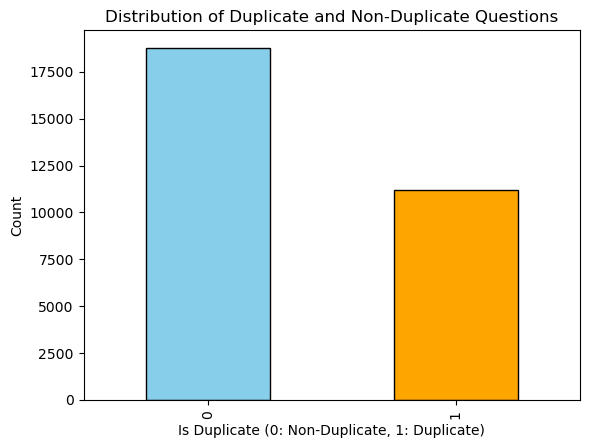

In [8]:
# Distribution of duplicate and non-duplicate questions
print(df["is_duplicate"].value_counts())  # Count of duplicates (1) and non-duplicates (0)
print((df["is_duplicate"].value_counts() / df["is_duplicate"].count()) * 100)  # Percentage distribution

# Plotting the distribution as a bar chart
df["is_duplicate"].value_counts().plot(kind="bar", color=['skyblue', 'orange'], edgecolor='black')

# Adding labels and title for the plot
plt.title('Distribution of Duplicate and Non-Duplicate Questions')
plt.xlabel('Is Duplicate (0: Non-Duplicate, 1: Duplicate)')
plt.ylabel('Count')

# Show the plot
plt.show()

In [9]:
qid = pd.Series(df["qid1"].to_list() + df["qid2"].to_list())
print("Total number of questions", qid.count())
print("Total number of unique questions", np.unique(qid).shape[0])

non_repeated_questions = qid.value_counts() == 1
print("Number of questions asked once", non_repeated_questions.sum())

repeated_questions = qid.value_counts() > 1
print("Number of questions repeated", repeated_questions.sum())

Total number of questions 60000
Total number of unique questions 55389
Number of questions asked once 51952
Number of questions repeated 3437


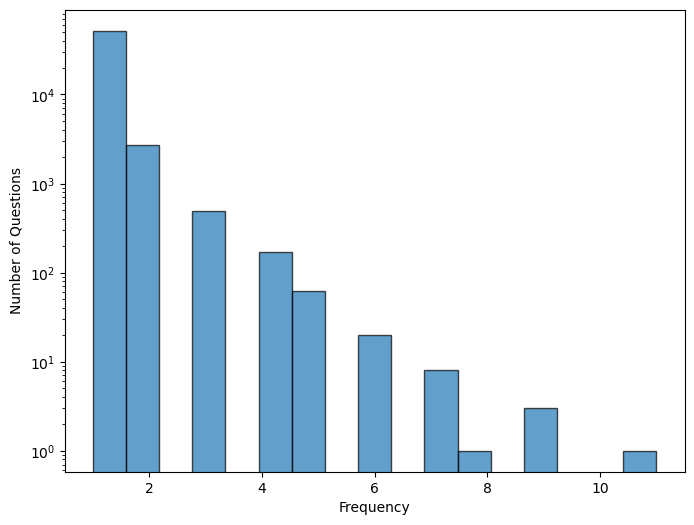

In [10]:
# Plotting histogram of the value counts
plt.figure(figsize=(8, 6))
plt.hist(qid.value_counts(), bins='auto', edgecolor='black', alpha=0.7)
plt.yscale('log')

# Adding labels and title
plt.xlabel('Frequency')
plt.ylabel('Number of Questions')

# Display the plot
plt.show()

### Pre-Processing

In [11]:
import re
import emoji
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
import ast
import string

# Load contractions and slang dictionaries
with open('contractions.txt', 'r') as file:
    content = file.read()
content = '{' + content.strip().rstrip(',') + '}'
contractions_dict = ast.literal_eval(content)

slang_dict = {}
with open('slang.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('=')
        if len(parts) == 2:
            slang_dict[parts[0].strip()] = parts[1].strip()

# Create an instance of the PorterStemmer
ps = PorterStemmer()

def preprocess_text(df):
    # Lower casing and encoding emojis
    df['question1'] = df['question1'].str.lower().apply(encode_emojis)
    df['question2'] = df['question2'].str.lower().apply(encode_emojis)
    
    # Contraction conversion
    df['question1'] = df['question1'].apply(contra_conv)
    df['question2'] = df['question2'].apply(contra_conv)

    # Basic preprocessing (replacing special characters, removing HTML tags)
    df['question1'] = df['question1'].apply(basic_preprocess)
    df['question2'] = df['question2'].apply(basic_preprocess)
    
    # Remove punctuations
    df['question1'] = df['question1'].apply(remove_punc)
    df['question2'] = df['question2'].apply(remove_punc)

    # Chat word treatment (slang replacement)
    df['question1'] = df['question1'].apply(chat_conv)
    df['question2'] = df['question2'].apply(chat_conv)

    # Stemming
    df['question1'] = df['question1'].apply(stem_words)
    df['question2'] = df['question2'].apply(stem_words)

    return df

def remove_punc(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

def encode_emojis(text):
    if isinstance(text, str):
        emojis = re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]', text)
        for emoji_ in emojis:
            text = text.replace(emoji_, emoji.demojize(emoji_))
        return text
    return text

def contra_conv(text):
    new_text = []
    if isinstance(text, str):
        for w in text.split():
            if w in contractions_dict:
                new_text.append(contractions_dict[w]) 
            else:
                new_text.append(w)
        return " ".join(new_text)
    return text

def basic_preprocess(q):
    q = q.replace('%', ' percent').replace('$', ' dollar ').replace('₹', ' rupee ').replace('€', ' euro ').replace('@', ' at ')
    q = q.replace(',000,000,000 ', 'b ').replace(',000,000 ', 'm ').replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Removing HTML tags
    q = BeautifulSoup(q, "html.parser").get_text()
    
    return q

def chat_conv(text):
    new_text = []
    if isinstance(text, str):
        for w in text.split():
            if w.upper() in slang_dict:
                new_text.append(slang_dict[w.upper()]) 
            else:
                new_text.append(w)
        return " ".join(new_text)
    return text

def stem_words(text):
    if isinstance(text, str):
        return " ".join([ps.stem(word) for word in text.split()])
    return text

# Assuming df is your DataFrame
df = preprocess_text(df)

In [12]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
21608,21608,27314,8469,what is the sahara and how do the averag tempe...,what is the sahara and how do the averag tempe...,1
3899,3899,7723,7724,is agnostic a religion,what is religion,0
32576,32576,42626,29115,what is the best program languag to know,what is the best program languag for learn pro...,1
22770,22770,42705,42706,will i pass a urin test,can you pass a urin test with bleach,0
3791,3791,7509,7510,what rank do most armi offic retir as,whi did major gaurav arya retir from the armi,0


In [ ]:
# Although I have not removed stop-words as they are required
# in the feature engineering step
'''
from nltk.corpus import stopwords

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    new_text = []
    if isinstance(text, str):
        for word in text.split():
            # Append only words that are not in the stop words
            if word.lower() not in stop_words:
                new_text.append(word)

        return " ".join(new_text)
    return text

df['question1'] = df['question1'].apply(remove_stopwords)
df['question2'] = df['question2'].apply(remove_stopwords)
'''

* I am deliberately ommiting spelling correction as I am working with a large data set

### Feature Engineering

In [14]:
# Creating our own Basic-features
df['q1_len'] = df['question1'].str.len() # Length of q1
df['q2_len'] = df['question2'].str.len() # Length of q2
df['q1_num_words'] = df['question1'].apply(lambda row : len(row.split(" "))) # number of words in q1
df['q2_num_words'] = df['question2'].apply(lambda row : len(row.split(" "))) # number of words in q2

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

df['common_words'] = df.apply(common_words, axis = 1)

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1) +  len(w2)

df['total_words'] = df.apply(total_words, axis = 1)

df['words_shared'] = round(df['common_words'] / df['total_words'], 2)

In [15]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,words_shared
31756,31756,58529,58530,doe lexapro caus weight gain,can hyperthyroid caus weight gain,0,28,33,5,5,3,10,0.30
31877,31877,58738,58739,the electron affin of fluorin is less than chl...,whi is the electron affin of fluorin less than...,1,54,62,10,12,10,21,0.48
14982,14982,28654,28655,what are the new secur featur in 2k rupe note ...,what are the new secur featur of the 2k rs not...,1,131,71,27,16,8,36,0.22
13112,13112,25202,25203,how can i beat procrastin,what are some of the time test way to beat pro...,1,25,53,5,11,2,16,0.12
6460,6460,12654,12655,what are some navi boot camp stori,what do you do in navi boot camp,0,34,32,7,8,4,14,0.29


Q1 Minimum characters: 0
Q1 Maximum characters: 362
Q1 Average number of characters: 53
Q2 Minimum characters: 0
Q2 Maximum characters: 1086
Q2 Average number of characters: 54
Q1 Minimum words: 1
Q1 Maximum words: 74
Q1 Average number of words: 10
Q2 Minimum words: 1
Q2 Maximum words: 248
Q2 Average number of words: 11


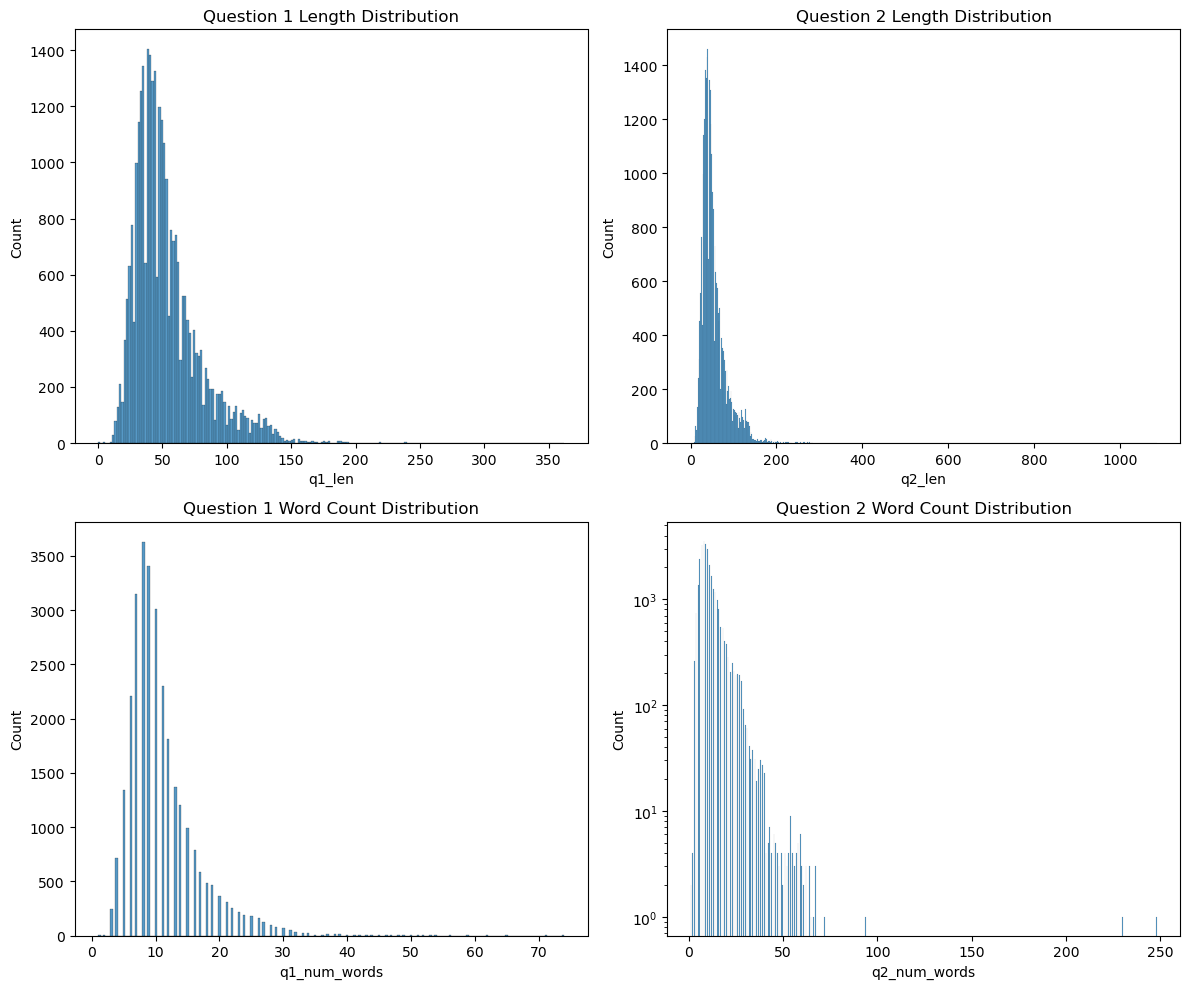

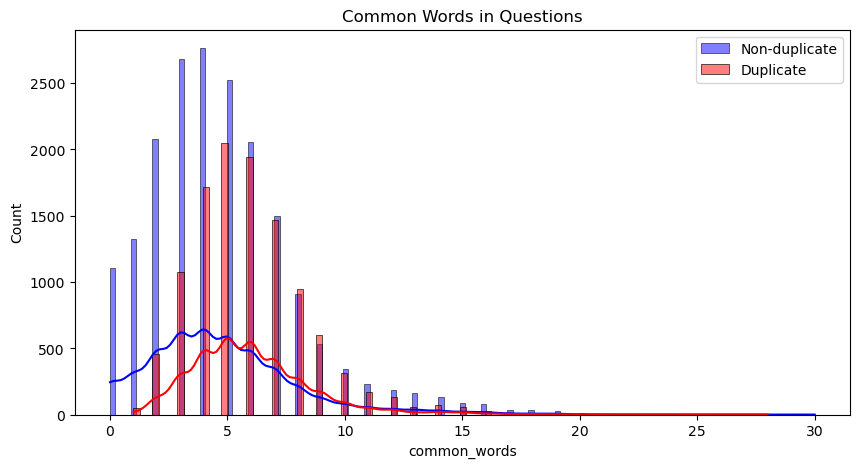

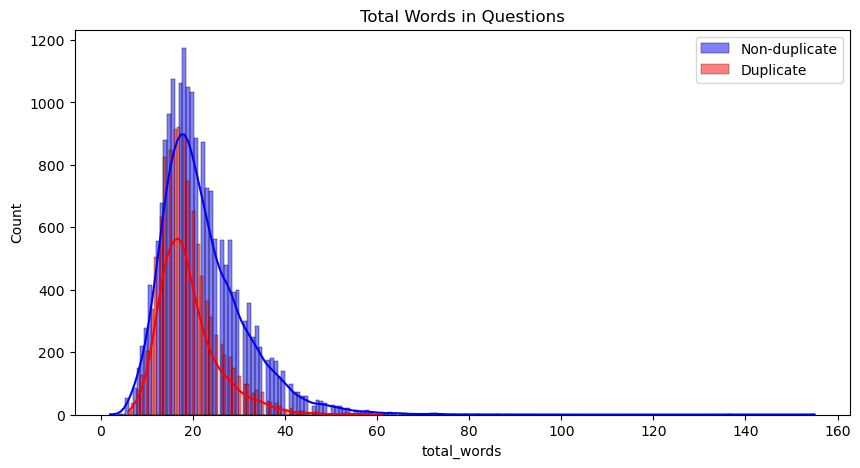

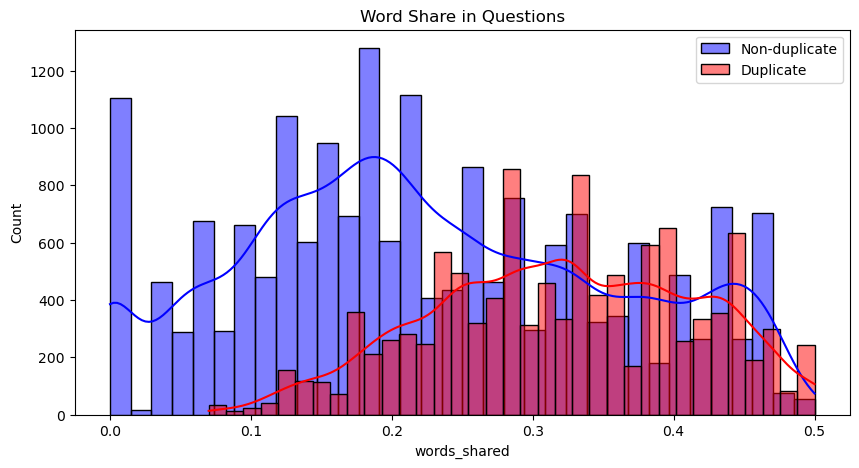

In [16]:
# Plot distributions for q1_len and q2_len
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['q1_len'], ax=axes[0, 0])
axes[0, 0].set_title('Question 1 Length Distribution')
print('Q1 Minimum characters:', df['q1_len'].min())
print('Q1 Maximum characters:', df['q1_len'].max())
print('Q1 Average number of characters:', int(df['q1_len'].mean()))

sns.histplot(df['q2_len'], ax=axes[0, 1])
axes[0, 1].set_title('Question 2 Length Distribution')
print('Q2 Minimum characters:', df['q2_len'].min())
print('Q2 Maximum characters:', df['q2_len'].max())
print('Q2 Average number of characters:', int(df['q2_len'].mean()))

# Plot distributions for q1_num_words and q2_num_words
sns.histplot(df['q1_num_words'], ax=axes[1, 0])
axes[1, 0].set_title('Question 1 Word Count Distribution')
print('Q1 Minimum words:', df['q1_num_words'].min())
print('Q1 Maximum words:', df['q1_num_words'].max())
print('Q1 Average number of words:', int(df['q1_num_words'].mean()))
plt.yscale('log')

sns.histplot(df['q2_num_words'], ax=axes[1, 1])
axes[1, 1].set_title('Question 2 Word Count Distribution')
print('Q2 Minimum words:', df['q2_num_words'].min())
print('Q2 Maximum words:', df['q2_num_words'].max())
print('Q2 Average number of words:', int(df['q2_num_words'].mean()))

plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot word_common for duplicate and non-duplicate
plt.figure(figsize=(10, 5))
sns.histplot(df[df['is_duplicate'] == 0]['common_words'], label='Non-duplicate', color='blue', kde=True)
sns.histplot(df[df['is_duplicate'] == 1]['common_words'], label='Duplicate', color='red', kde=True)
plt.title('Common Words in Questions')
plt.legend()
plt.show()

# Plot word_total for duplicate and non-duplicate
plt.figure(figsize=(10, 5))
sns.histplot(df[df['is_duplicate'] == 0]['total_words'], label='Non-duplicate', color='blue', kde=True)
sns.histplot(df[df['is_duplicate'] == 1]['total_words'], label='Duplicate', color='red', kde=True)
plt.title('Total Words in Questions')
plt.legend()
plt.show()

# Plot word_share for duplicate and non-duplicate
plt.figure(figsize=(10, 5))
sns.histplot(df[df['is_duplicate'] == 0]['words_shared'], label='Non-duplicate', color='blue', kde=True)
sns.histplot(df[df['is_duplicate'] == 1]['words_shared'], label='Duplicate', color='red', kde=True)
plt.title('Word Share in Questions')
plt.legend()
plt.show()

In [17]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [18]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [19]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if not strs:
        return length_features
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [20]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [21]:
# Fuzzy Features
from fuzzywuzzy import fuzz
def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [22]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [23]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
23917,23917,44755,37295,what is your opinion of masturb,what is your opinion on masturb,1,31,31,6,6,...,0.833319,1.0,1.0,0.0,6.0,0.687500,97,97,97,97
903,903,1801,1802,whi there is so much nuditi content in game of...,whi is there so much nuditi in the game of thr...,1,53,57,11,13,...,0.769225,0.0,1.0,2.0,12.0,0.296296,76,79,82,92
8400,8400,16378,16379,how do you use the leagu of legend build calcul,what is a good intel build for leagu of legend,0,47,46,10,10,...,0.399996,0.0,0.0,0.0,10.0,0.340426,45,46,56,63
18912,18912,35784,35785,can martin omalley win,where is martin omalley from,0,22,28,4,5,...,0.399992,0.0,0.0,1.0,4.5,0.695652,64,73,68,78
10882,10882,21051,21052,how long should you signal befor you turn,befor green signal in traffic most of vehicl b...,0,41,125,8,25,...,0.080000,0.0,0.0,17.0,16.5,0.190476,23,34,31,49


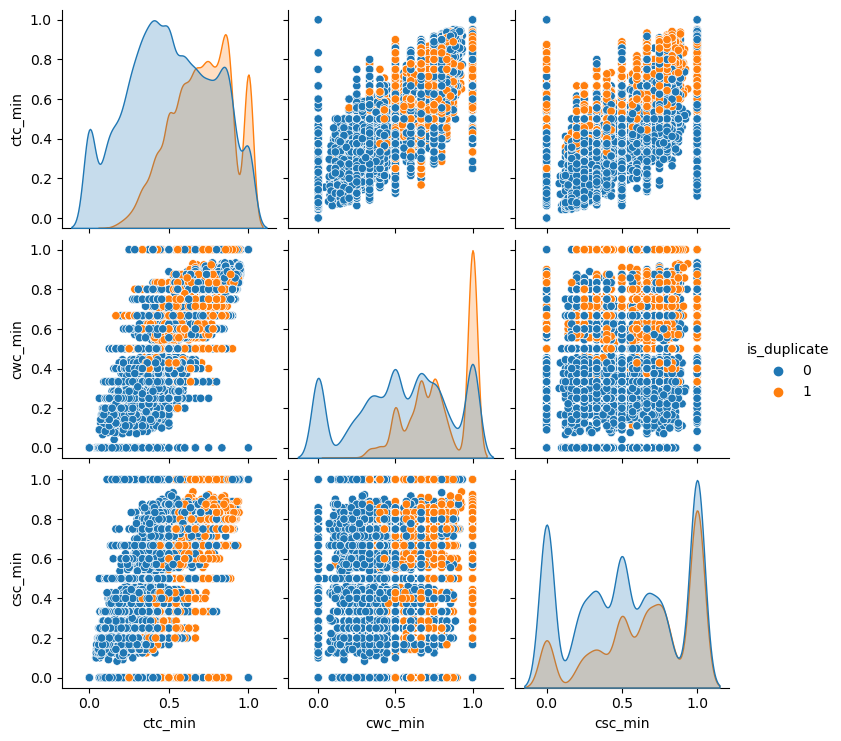

In [24]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

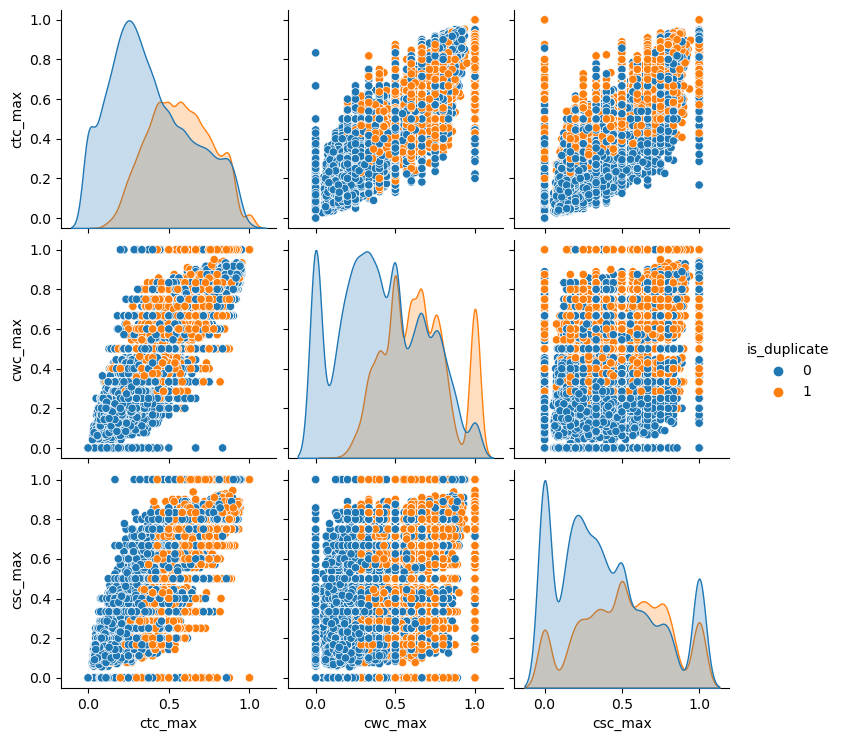

In [25]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

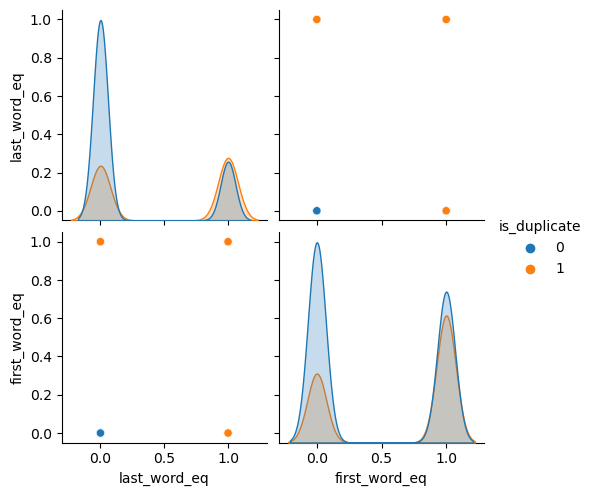

In [26]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

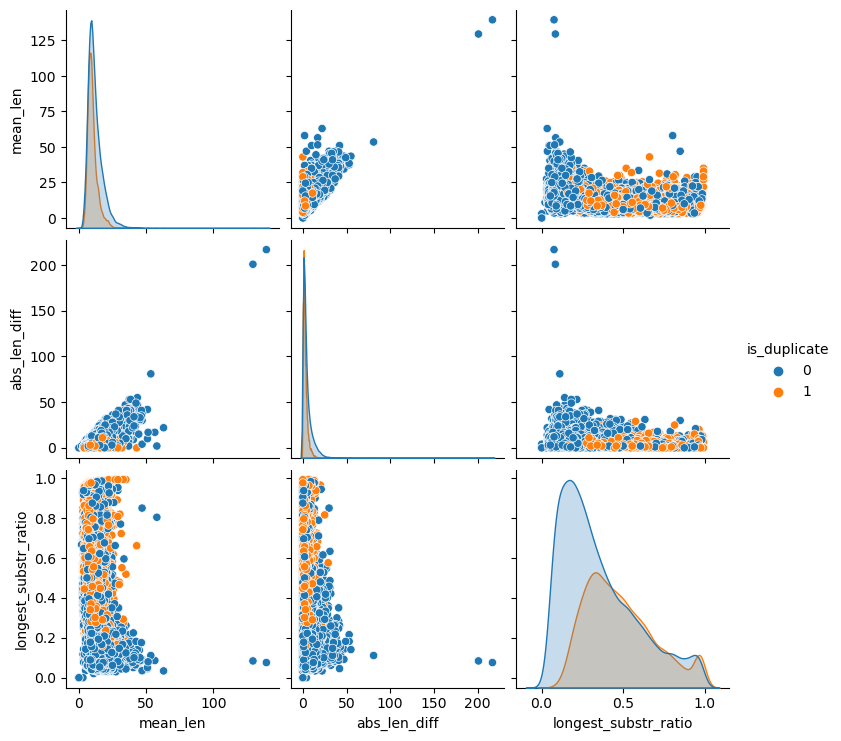

In [27]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

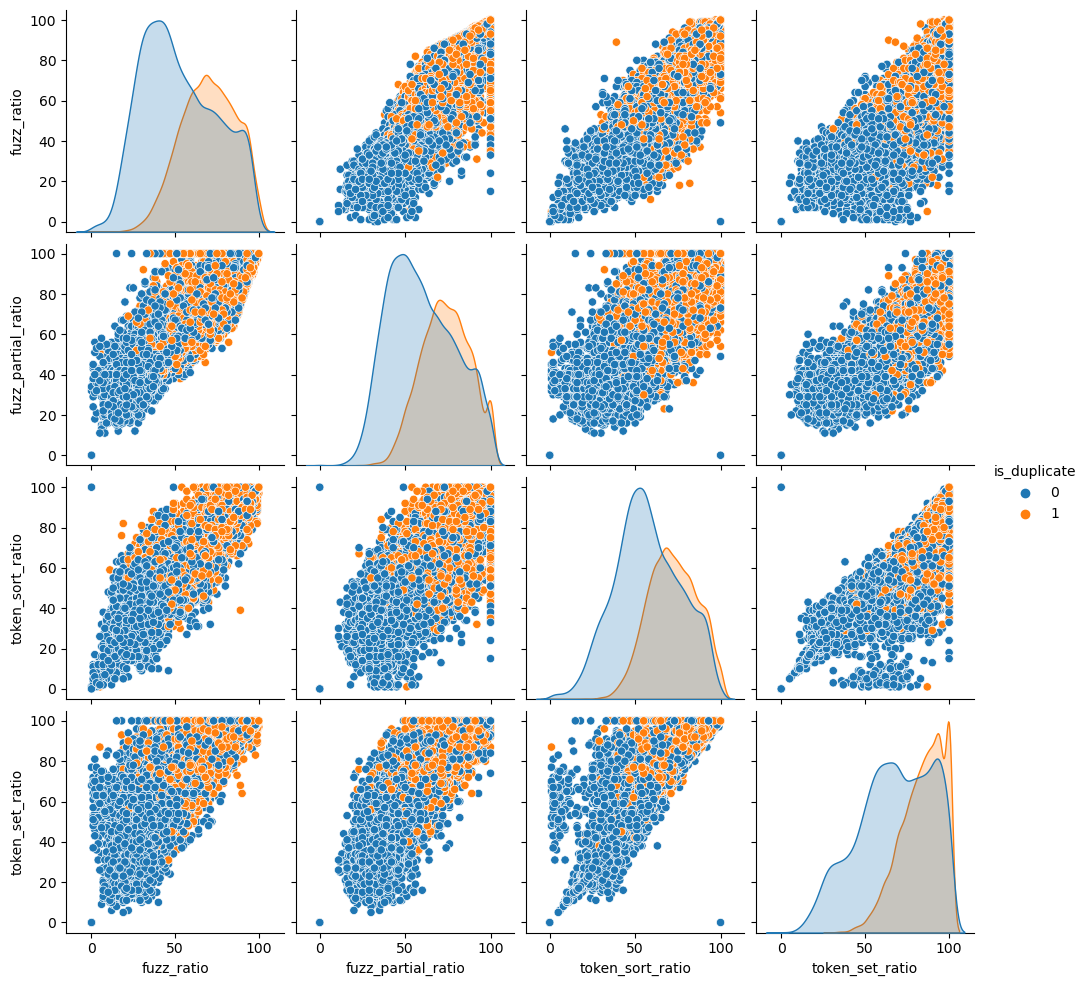

In [28]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [29]:
# seperate questions
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
17813,what are some unusu aspect about polit and gov...,what are some unusu aspect about polit and gov...
6857,what fee doe hiredcom charg,how do i charg and enforc fee without a staff
7672,“if homosexu is a sexual orient we embrac shou...,in the futur will pedophilia be view as a diff...
9704,what are the best train institut of pmp in delhi,what are some good pmp train classroom session...
14303,what are the innov decis taken by delhi aap go...,how is aap differ from other parti


In [30]:
# seperate features
features_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
features_df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,words_shared,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
17813,0,58,60,11,11,10,22,0.45,0.799984,0.799984,...,0.909083,0.0,1.0,0.0,11.0,0.898305,90,91,90,95
6857,0,27,45,5,10,2,15,0.13,0.499988,0.399992,...,0.199998,0.0,0.0,5.0,7.5,0.214286,33,44,56,56
7672,0,83,76,16,14,5,29,0.17,0.499992,0.374995,...,0.312498,0.0,0.0,2.0,15.0,0.194805,38,41,69,70
9704,1,48,59,10,11,6,21,0.29,0.599988,0.428565,...,0.545450,0.0,1.0,1.0,10.5,0.183673,54,46,62,72
14303,0,90,34,17,7,5,24,0.21,0.999967,0.333330,...,0.294116,1.0,0.0,10.0,12.0,0.685714,52,74,50,89


In [31]:
from sklearn.feature_extraction.text import CountVectorizer
# Get sample-space of all words
questions = list(ques_df['question1']) + list(ques_df['question2'])

# set max_features to 3000
cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [32]:
# create df with columns as features and rows as vector then concatinate both df's
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

* so a total of 6000 columns, 3000 from q1 and another 3000 from q2
* We will now mix these 6000 with the 23 features we created earlier making a total of 6023 final features

In [33]:
# creating featurised data-frame
features_df = pd.concat([features_df, temp_df], axis=1)
print(features_df.shape)
features_df.head()

(30000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,words_shared,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
17813,0,58,60,11,11,10,22,0.45,0.799984,0.799984,...,0,0,0,0,0,0,0,0,0,0
6857,0,27,45,5,10,2,15,0.13,0.499988,0.399992,...,0,0,0,0,0,0,0,0,0,0
7672,0,83,76,16,14,5,29,0.17,0.499992,0.374995,...,0,0,0,0,0,0,0,0,0,0
9704,1,48,59,10,11,6,21,0.29,0.599988,0.428565,...,0,0,0,0,0,0,0,0,0,0
14303,0,90,34,17,7,5,24,0.21,0.999967,0.333330,...,0,0,0,0,0,0,0,0,0,0


### Modelling & Evaluation

In [34]:
# get training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features_df.iloc[:, 1:].values, features_df.iloc[:, 0].values, test_size=0.2, random_state = 69)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7863333333333333

In [36]:
from sklearn.metrics import confusion_matrix
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3228,  533],
       [ 749, 1490]], dtype=int64)